In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import seaborn as sns
%matplotlib inline

feature_name_df = pd.read_csv('features.txt', sep='\s+', header=None, names=['column_index', 'column_name'])

feature_name = feature_name_df.iloc[:,1].values.tolist()
print('전체 피처명에서 10개만 추출:', feature_name[:10])

전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [3]:
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index'] > 1].count())
feature_dup_df[feature_dup_df['column_index'] > 1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [4]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) if x[1]>0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [5]:
def get_human_dataset():
    feature_name_df = pd.read_csv('features.txt', sep='\s+', header=None, names=['column_index', 'column_name'])
    
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    feature_name = new_feature_name_df.iloc[:,1].values.tolist()
    
    x_train = pd.read_csv('./train/X_train.txt', sep='\s+', names=feature_name)
    x_test = pd.read_csv('./test/X_test.txt', sep='\s+', names=feature_name)
    
    y_train = pd.read_csv('./train/y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv('./test/y_test.txt', sep='\s+', header=None, names=['action'])
    
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = get_human_dataset()

In [6]:
print('##학습 피처 데이터셋 info()')
print(x_train.info())

##학습 피처 데이터셋 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [7]:
print(y_train['action'].value_counts())

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


In [8]:
rt_clf = RandomForestClassifier(random_state=0)
rt_clf.fit(x_train, y_train)
pred = rt_clf.predict(x_test)
accuracy = accuracy_score(y_test, pred)
print('Random Forest Accuracy: {0:.4f}'.format(accuracy))

print('RandomForest 기본 하이퍼 파라미터:\n', rt_clf.get_params())

Random Forest Accuracy: 0.9253
RandomForest 기본 하이퍼 파라미터:
 {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [10]:
params = {
    'n_estimators' : [100],
    'max_depth' : [8, 12, 18],
    'min_samples_split' : [8,16,20]
}

rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rt_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(x_train, y_train)

print('GridSearchCV 최고 평균 정확도 수치 : {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

GridSearchCV 최고 평균 정확도 수치 : 0.9127
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 18, 'min_samples_split': 16, 'n_estimators': 100}


In [13]:
rf_clf1 = RandomForestClassifier(n_estimators=300, max_depth=18, min_samples_leaf=16, min_samples_split=16, random_state=0)
rf_clf1.fit(x_train, y_train)
pred = rf_clf1.predict(x_test)

print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

예측 정확도: 0.9152


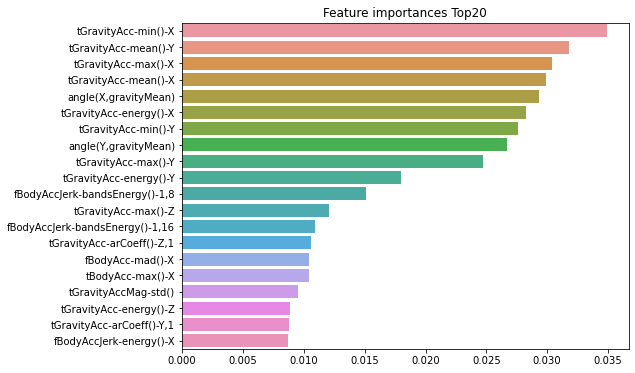

In [14]:
ftr_importances_values = rf_clf1.feature_importances_

ftr_importances = pd.Series(ftr_importances_values, index=x_train.columns)

ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()